<a href="https://www.kaggle.com/code/stefancomanita/news-coverage-of-the-ukraine-conflict?scriptVersionId=165125236" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bbc-news/bbc_news.csv


# Intro
Hello, in this small notebook we will look at the news coverage of the Ukraine conflict, mostly the number of mentions in the news and the sentiment of this mentions.

The dataset we will use a dataset that has BBC news, that contains the news title, description and publication date.

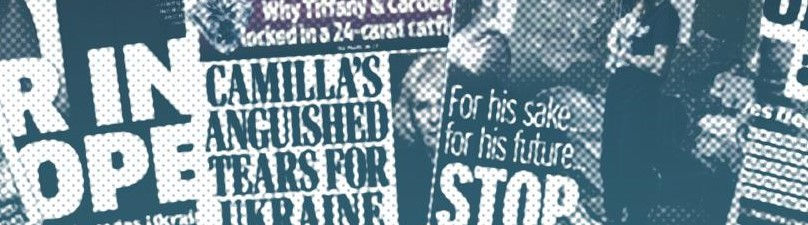

For this we will find the news of interest for this experiment (news mentionin Ukraine, Kyiv, Kiev, etc) and group them by week. And check the number of mentions in each week and the sentiment of the news for that week.

The number of mentions is just plain pandas data negineering, but for the snetiment analysis part we will use Hugging Face.

# Imports and minor setup
We will start by adding all the imports that we need and do some minor setup.

In [2]:
import pandas as pd

from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

# Loading the data and quick EDA
In this section we are goind to load the data and do some very minor EDA.

In [3]:
df: pd.DataFrame = pd.read_csv("/kaggle/input/bbc-news/bbc_news.csv")
print(df.columns)
# drop the columns we are not interested in
df: pd.DataFrame = df.drop(["guid", "link"], axis = 1)

# print the shape of the dataframe and the head
print(df.shape)


Index(['title', 'pubDate', 'guid', 'link', 'description'], dtype='object')
(30123, 3)


In [4]:
# no EDA is complete without a show of the head
df.head

<bound method NDFrame.head of                                                    title                        pubDate                                        description
0      Ukraine: Angry Zelensky vows to punish Russian...  Mon, 07 Mar 2022 08:01:56 GMT  The Ukrainian president says the country will ...
1      War in Ukraine: Taking cover in a town under a...  Sun, 06 Mar 2022 22:49:58 GMT  Jeremy Bowen was on the frontline in Irpin, as...
2             Ukraine war 'catastrophic for global food'  Mon, 07 Mar 2022 00:14:42 GMT  One of the world's biggest fertiliser firms sa...
3      Manchester Arena bombing: Saffie Roussos's par...  Mon, 07 Mar 2022 00:05:40 GMT  The parents of the Manchester Arena bombing's ...
4      Ukraine conflict: Oil price soars to highest l...  Mon, 07 Mar 2022 08:15:53 GMT  Consumers are feeling the impact of higher ene...
...                                                  ...                            ...                                                .

# Preparing the Hugging Face transformers
We will use the sentiment-analysis pipeline but we will provide to it a custom model and tokenizer. As we deal with english we will use the distilled bert model and tokenizer.

In [5]:
modelName = "distilbert-base-uncased-finetuned-sst-2-english"

myTokenizer = AutoTokenizer.from_pretrained(modelName)
myModel = AutoModelForSequenceClassification.from_pretrained(modelName, max_length=2048)

classifier = pipeline("sentiment-analysis", model=myModel, tokenizer=myTokenizer)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

# Declaring utility methods
Next let's declare a couple of method we will use

In [6]:
# this method determines if a news if of interest to us, we determine this in a naive way, just looking for some keywords.
def isNewsOfInterest(text):
    for f in ["ukrain", "kiev", "kyiv", "odesa", "kherson", "zelensky", "zaluzhnyi", "budanov", "syrskyi"]:
        if f in text:
            return True

    return False

In [7]:
# this mehod determines the sentiment score using hugging face. for negative we negate the value
def computeSentimentScore(text):
    out = classifier(text)

    if out[0]['label'] == 'POSITIVE':
        return out[0]['score']
    else:
        return out[0]['score'] * -1

# Preparing the data
In this section we want to identify the news of interest to us, group them by week and calculate the sentiment for them.

In [8]:
# declare a map that will hold the data
data = {}

for row in tqdm(df.iterrows(), total=len(df)):
    # the text is the title and the description, to lower case
    text = (row[1]["title"] + row[1]["description"]).lower()
    
    if isNewsOfInterest(text):
        date = pd.to_datetime(row[1]["pubDate"])

        # extract the year and week of the news
        year = date.year
        week = date.week

        if year in data:
            if week in data[year]:
                found = data[year][week]
                foundCount = found["count"]
                data[year][week]["count"] = foundCount + 1
                data[year][week]["sentiment"].append(computeSentimentScore(text))
            else:
                foundMap = data[year]
                foundMap[week] = {"count": 1, "sentiment": [computeSentimentScore(text)]}
        else:
            data[year] = {week: {"count": 1, "sentiment": [computeSentimentScore(text)]}}

  0%|          | 0/30123 [00:00<?, ?it/s]

In [9]:
# here we prepare a bunch of lists that will hold the values that we will transform to a dataframe
years = []
weeks = []
mentions = []
weekLabels = []
sentiments = []

for y in data:
    for w in tqdm(data[y], total=len(data[y])):
        years.append(y)
        weeks.append(w)
        mentions.append(data[y][w]["count"])
        weekLabels.append(pd.to_datetime((y * 1000) + (w * 7), format='%Y%j').date())
        sentimentValues = data[y][w]["sentiment"]
        sentimentOfTheWeek = sum(sentimentValues) / len(sentimentValues)
        sentiments.append(sentimentOfTheWeek)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

In [10]:
# this is just a check, all the values should be the same
print(len(years), len(weeks), len(mentions), len(weekLabels), len(sentiments))

105 105 105 105 105


In [11]:
df = pd.DataFrame(
    {'year': years,
     'week': weeks,
     'mentions': mentions,
     'weekLabels': weekLabels,
     'sentiment': sentiments
    })

df = df.sort_values(by=['year', 'week'])
df = df.reset_index(drop=True)

In [12]:
# print the shape and a part of the data
print(df.head(20))
print(df.shape)

numberOfBins = 12

    year  week  mentions  weekLabels  sentiment
0   2022     9        22  2022-03-04  -0.374819
1   2022    10       158  2022-03-11  -0.416849
2   2022    11       104  2022-03-18  -0.560479
3   2022    12        72  2022-03-25  -0.697629
4   2022    13        56  2022-04-01  -0.504394
5   2022    14        60  2022-04-08  -0.494893
6   2022    15        60  2022-04-15  -0.519246
7   2022    16        42  2022-04-22  -0.619265
8   2022    17        51  2022-04-29  -0.462042
9   2022    18        56  2022-05-06  -0.649341
10  2022    19        42  2022-05-13  -0.351273
11  2022    20        48  2022-05-20  -0.629264
12  2022    21        50  2022-05-27  -0.559053
13  2022    22        36  2022-06-03  -0.166288
14  2022    23        23  2022-06-10  -0.694059
15  2022    24        29  2022-06-17  -0.622478
16  2022    25        26  2022-06-24  -0.137222
17  2022    26        25  2022-07-01  -0.730380
18  2022    27        17  2022-07-08  -0.632972
19  2022    28        16  2022-07-15  -0

# News mentions of the conflict
Here we will plot the the number of the mentions of the conflict grouped by week.

Text(0.5, 1.0, 'Mentions in the news, per week')

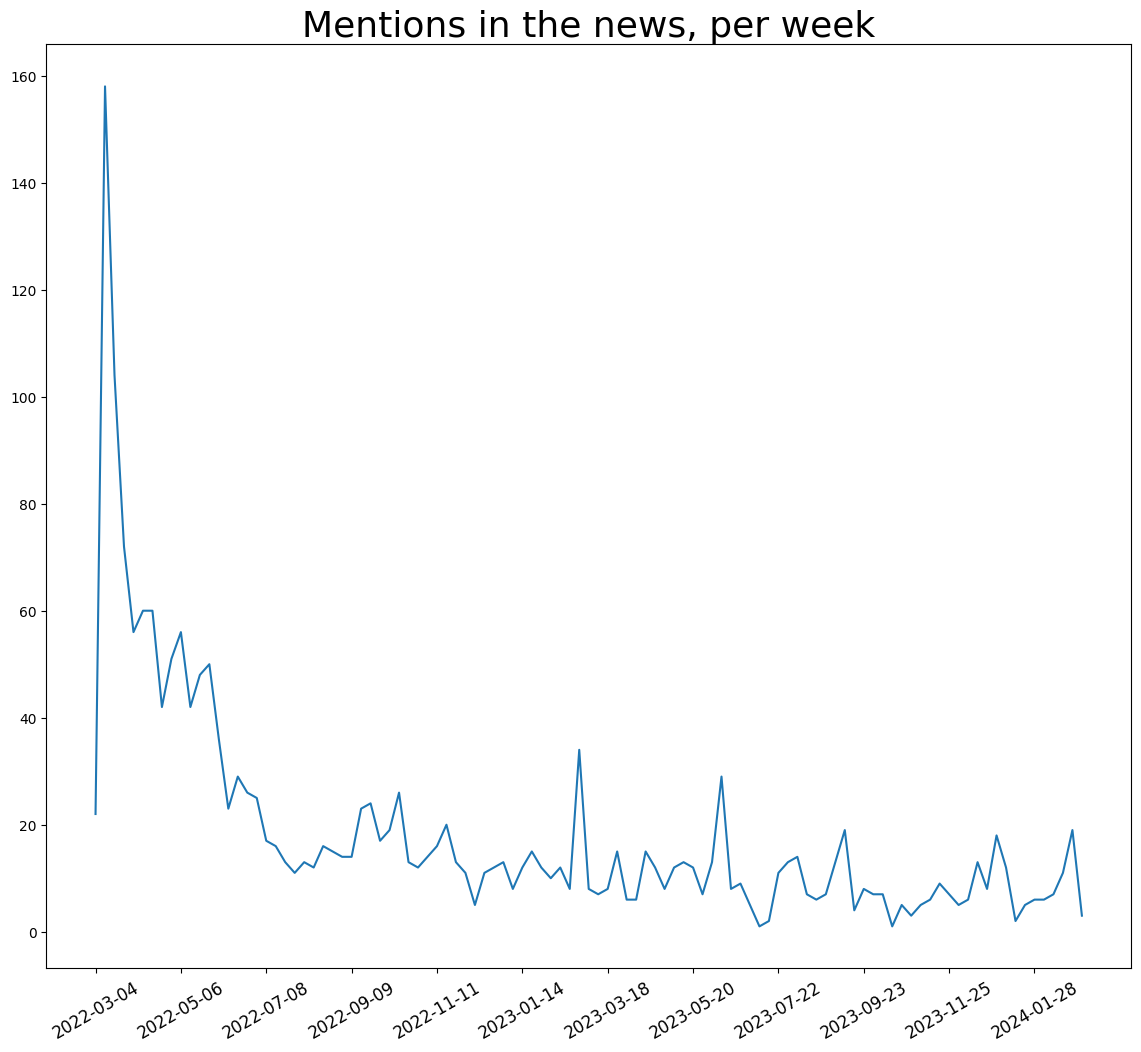

In [13]:
plt.figure(figsize=(14, 12))
df["mentions"].plot()
plt.xticks(range(len(df["weekLabels"])), df["weekLabels"], size='large')
plt.xticks(rotation = 30)
plt.locator_params(axis='x', nbins=numberOfBins)
plt.title('Mentions in the news, per week', fontsize = 26)

# News sentiment of the conflict
Now we will plot the sentiment of the news, again grouped by week.

Text(0.5, 1.0, 'Sentiment of the news, per week, higher is more positive')

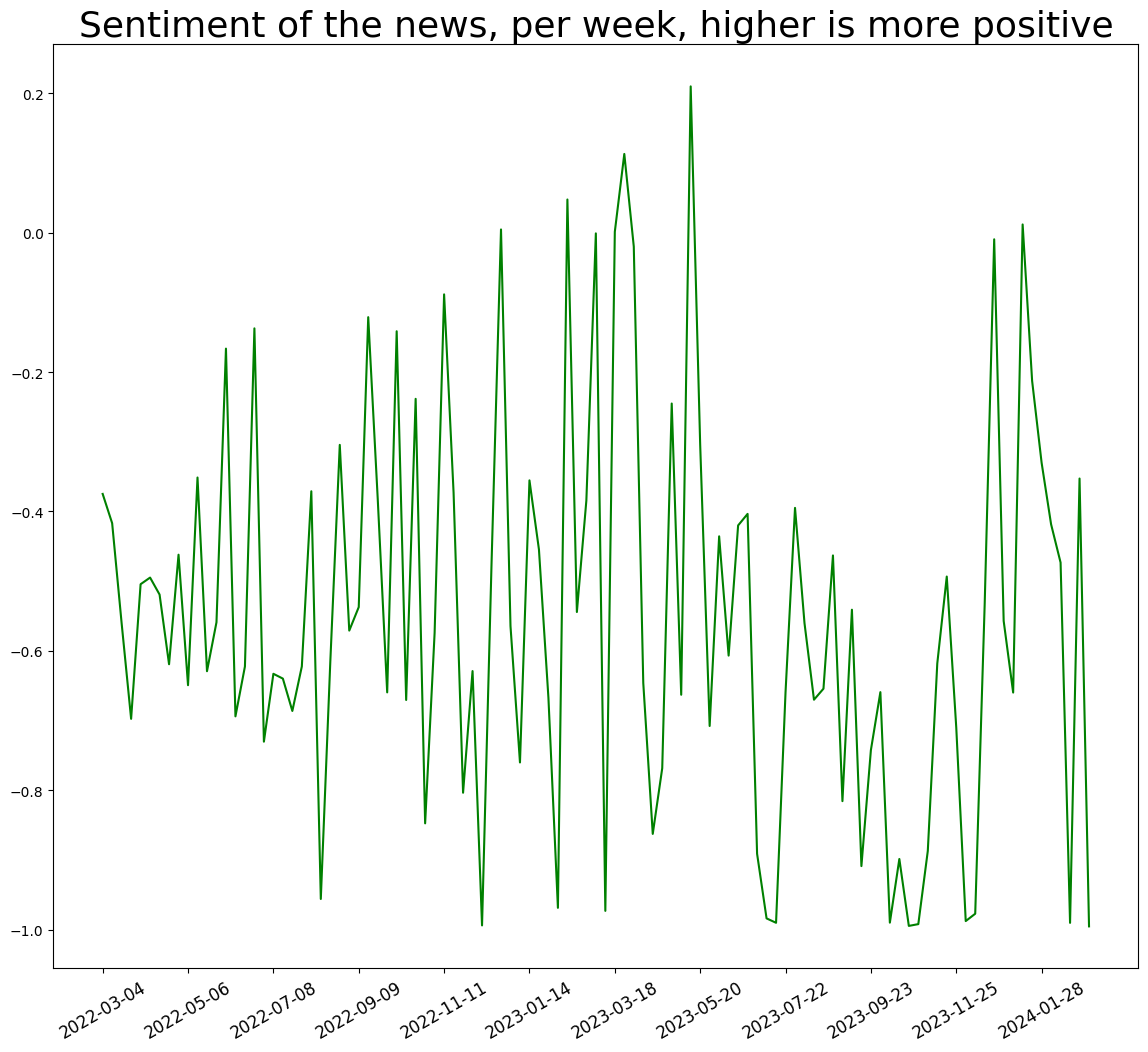

In [14]:
plt.figure(figsize=(14, 12))
df["sentiment"].plot(color='green')
plt.xticks(range(len(df["weekLabels"])), df["weekLabels"], size='large')
plt.xticks(rotation = 30)
plt.locator_params(axis='x', nbins=numberOfBins)
plt.title('Sentiment of the news, per week, higher is more positive', fontsize = 26)

# Finish!
You have made it to the finish, thank you. Please upvote if you liked it :)